In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import os
import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import display, Image

2025-10-16 12:55:02.168225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 12:55:02.241727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 12:55:03.470160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')

# Simulate a new trajectory

In [5]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu',k=1).h

In [6]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, dt=0.1, tsim_length=20, trajectory_shape='alternating')

In [7]:
measurement_noise_stds = {'optic_flow': 0.2,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

In [8]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

In [9]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Load the trained model

In [10]:
model_weights = 'altitude_estimator_ann_trained_weights.h5'
model_config = 'altitude_estimator_ann_trained_config.json'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

In [11]:
model, config = keras_ann_utility.load_model_complete('altitude_estimator_ann_trained')

✓ Loaded configuration from: altitude_estimator_ann_trained_config.json
✓ Loaded weights from: altitude_estimator_ann_trained_weights.h5

Model loaded successfully!


2025-10-16 12:55:14.380050: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Create a fast inference model

In [12]:
# almost direct from Claude
def create_fast_inference_model(trained_model):
    """
    Create an optimized version of the model for fast inference using XLA compilation.
    Removes training-specific components (dropout, regularization).

    Note: The first prediction will be slower as it includes compilation time.
    Subsequent predictions will be fast.

    Parameters:
    -----------
    trained_model : keras model
        The trained model

    Returns:
    --------
    inference_func : tf.function
        Optimized inference function for predictions

    Example:
    --------
    >>> fast_predict = create_fast_inference_model(model)
    >>> # First call is slow (compilation)
    >>> predictions = fast_predict(X_core_batch, X_aux_batch) # X_aux_batch is optional, depending on model
    >>> # Subsequent calls are fast
    >>> predictions = fast_predict(X_core_batch2, X_aux_batch2) # X_aux_batch is optional, depending on model
    """
    # Get the base functional model (without custom training logic)
    inputs = trained_model.inputs
    outputs = trained_model.outputs

    # Create inference-only model
    inference_model = keras.Model(inputs=inputs, outputs=outputs)

    # Get only trainable weights (excludes metric trackers)
    trainable_weights = trained_model.trainable_weights
    inference_trainable_weights = inference_model.trainable_weights

    # Copy weights
    for target_weight, source_weight in zip(inference_trainable_weights, trainable_weights):
        target_weight.assign(source_weight)

    # Create optimized prediction function
    @tf.function(jit_compile=True)  # XLA compilation for speed
    def fast_predict(x_core, x_aux=None):
        if x_aux is None:
            return inference_model([x_core], training=False)
        else:
            return inference_model([x_core, x_aux], training=False)

    print("✓ Fast inference model created with XLA compilation")
    print("  First prediction will be slow (includes compilation)")
    print("  Subsequent predictions will be fast")
    print("  Use: predictions = fast_predict(X_core_tensor)")
    print("  --- OR ---")
    print("  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)")
    print("  Note: Inputs must be TensorFlow tensors (use tf.constant())")

    return fast_predict

In [13]:
fast_predict = create_fast_inference_model(model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor)
  --- OR ---
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


# Augment the new trajectory as with the training data

In [14]:
time_window = 10
input_names = ['optic_flow', 'accel_x', 'accel_z']
input_offsets = np.arange(time_window)*-1
y_noisy_df_aug = keras_ann_utility.collect_offset_rows(y_noisy_df,
                                       states=input_names,
                                       controls=None,
                                       outputs=None,
                                       state_offsets=input_offsets,
                                       control_offsets=None,
                                       output_offsets=None)

# Run the ANN on the measurements from the new trajectory

In [15]:
z_pred = []
for i in range(len(y_noisy_df_aug)):
    y = y_noisy_df_aug.values[i,:]
    y_tf = tf.constant(np.atleast_2d(y))
    z_pred.append( fast_predict(y_tf) )

2025-10-16 12:55:16.170741: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xdb6a160 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-16 12:55:16.170799: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-10-16 12:55:16.183950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-16 12:55:16.353412: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
z_pred = np.ravel(tf.stack(z_pred).numpy())

# Visualize the results

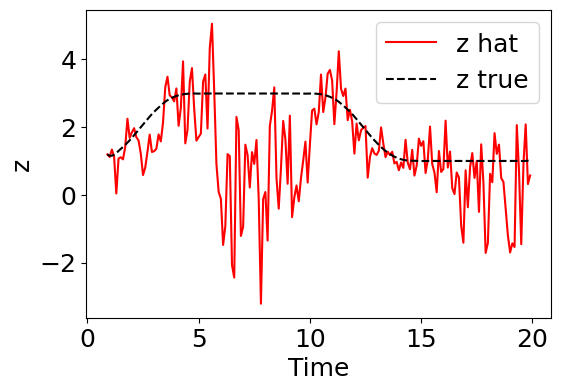

In [17]:
ax = plot_tme(t_sim[time_window-1:], x_sim_df.z.values[time_window-1:], None, z_pred, label_var='z')

### Add shading for the high acceleration regions

In [18]:
# From claude
def find_contiguous_chunks(lst):
    """
    Find contiguous chunks in a list of integers.

    Parameters:
    -----------
    lst : list of int
        List of integers

    Returns:
    --------
    list of lists : Each sublist contains a contiguous sequence
    """
    if not lst:
        return []

    lst = sorted(lst)
    chunks = []
    current_chunk = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] == lst[i-1] + 1:
            current_chunk.append(lst[i])
        else:
            chunks.append(current_chunk)
            current_chunk = [lst[i]]

    chunks.append(current_chunk)
    return chunks

In [25]:
accel_threshold = 3
ix_high_accel = np.where( np.abs(y_noisy_df[time_window-1:].accel_x.values) > accel_threshold)[0].tolist()
high_accel_chunks = find_contiguous_chunks(ix_high_accel)

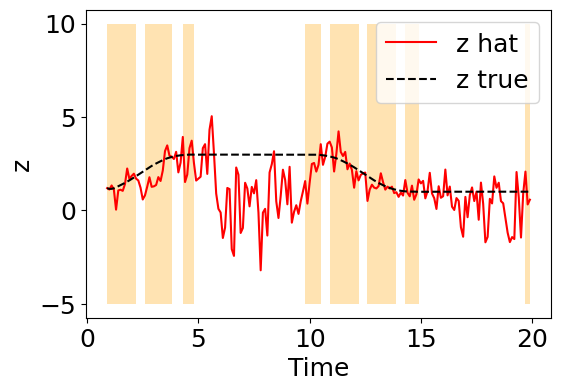

In [26]:
ax = plot_tme(t_sim[time_window-1:], x_sim_df.z.values[time_window-1:], None, z_pred, label_var='z')
for chunk in high_accel_chunks:
    ax.fill_betweenx([-5, 10],
                     t_sim[time_window-1:][chunk[0]],
                     t_sim[time_window-1:][chunk[-1]],
                     edgecolor='none', facecolor='orange', alpha=0.3)

# Exercises

To improve the performance your best options are most likely:
* Use a larger time window for the delay embedding and retrain the model
* Increase the training set size and retrain the model
